In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
drebin_all = pd.read_csv('drebin.csv')

D:\Galib\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (92) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#dataset load
drebin_apis = pd.read_csv('drebin.csv', 
                         usecols= [*range(0, 6),*range(7, 13),*range(14,19)
                                  ,21,23,24,*range(28,38),41,43,46,48,51,54,
                                   57,58,59,62,64,68,70,78,80,*range(83,87),
                                   *range(92, 95),98,101,102,104,109,123,128,
                                   140,142,145,147,148,152,155,156,158,167,
                                   171,172,180,190,215])

In [4]:
#dataset load
drebin_permissions = pd.read_csv('drebin.csv', 
                         usecols= [6,13,19,20,22,26,27,38,39,40,42,45,47,49,
                                   50,52,56,60,61,63,65,67,69,71,72,75,76,77,
                                   *range(87,92),95,99,103,105,106,108,
                                   *range(110,117), *range(119,123),*range(124,128),
                                   *range(129,135),*range(136,140),143,144,146,
                                   151,153,154,159,160,*range(162,167),168,169,170,
                                   173,175,176,177,181,182,183,184,187,188,189,
                                   191,192,193,195,196,*range(198,215),215])

In [5]:
drebin_all.shape

(15036, 216)

In [6]:
drebin_permissions.shape

(15036, 114)

In [7]:
X_all = drebin_all.iloc[0:,0:215]  #independent columns
y_all = drebin_all.iloc[0:,-1]
X_all["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X_all['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [8]:
X_permissions = drebin_permissions.iloc[0:,0:113]  #independent columns


In [9]:
X_permissions.dtypes

SEND_SMS                      int64
READ_PHONE_STATE              int64
GET_ACCOUNTS                  int64
RECEIVE_SMS                   int64
READ_SMS                      int64
                              ...  
WRITE_EXTERNAL_STORAGE        int64
ACCESS_FINE_LOCATION          int64
SET_WALLPAPER_HINTS           int64
SET_PREFERRED_APPLICATIONS    int64
WRITE_SECURE_SETTINGS         int64
Length: 113, dtype: object

In [10]:
#drebin_all.info()
X_apis = drebin_apis.iloc[0:,0:73]  #independent columns
X_apis["TelephonyManager.getSimCountryIso"] = pd.to_numeric(X_apis['TelephonyManager.getSimCountryIso'], errors='coerce').fillna(0).astype(int)

In [11]:
y_all = y_all.map(dict(S=1, B=0))

In [12]:
y_all

0        1
1        1
2        1
3        1
4        1
        ..
15031    0
15032    0
15033    0
15034    0
15035    0
Name: class, Length: 15036, dtype: int64

In [13]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_permissions, y_all, test_size = 0.5, random_state = 0)


In [14]:
#mandatory import 
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from sklearn.feature_selection import RFE

In [15]:
with_corr=[]
without_corr=[]
pre = []
rec = []
fs = []
acc = []
auc = []
def clear_metrics(): 
    with_corr.clear()
    without_corr.clear()
    pre.clear()
    rec.clear()
    fs.clear()
    acc.clear()
    auc.clear()

In [16]:
import csv, os, time 
def results_to_csv(title, corr=0):
    directory = "PERMISSIONS_CSV"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
    print(parent_dir)
    
#     if not parent_dir == 'Malgenome':
#         os.chdir('Malgenome')
#         parent_dir = os.getcwd()
#         print(parent_dir)
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_CSV'):
        os.mkdir(path)
    os.chdir(path) 
    print(1)
    with open(title+ '.csv', 'w') as f:
        writer = csv.writer(f)
        if corr==1: 
            writer.writerow(['Without Correlation', 'With Correlation','Accuracy','Precision', 'Recall', 'F1','AUC'])
            writer.writerows(zip(without_corr, with_corr, acc, pre, rec, fs, auc))
            print(without_corr, with_corr, acc, pre, rec, fs, auc)
        else: 
            writer.writerow(['Accuracy','Precision', 'Recall', 'F1','AUC'])
            
            writer.writerows(zip(acc, pre, rec, fs, auc))
    os.chdir('../')
        
def allscore(scores,i,with_correlation=0):
    without_corr.insert(i,i)
    if with_correlation!=0:
        with_corr.insert(i,with_correlation)
    acc.insert(i,scores['test_accuracy'].mean())
    fs.insert(i,scores['test_f1'].mean())
    pre.insert(i,scores['test_precision'].mean())
    rec.insert(i,scores['test_recall'].mean())
    auc.insert(i,scores['test_roc_auc'].mean())
    print("Accuracy: %0.4f   (+/- %0.4f)" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std() * 2))
    print("Precision: %0.4f   (+/- %0.4f)" % (scores['test_precision'].mean(), scores['test_accuracy'].std() * 2))
    print("Recall: %0.4f   (+/- %0.4f)" % (scores['test_recall'].mean(), scores['test_accuracy'].std() * 2))
    print("F-1 Score: %0.4f   (+/- %0.4f)" % (scores['test_f1'].mean(), scores['test_accuracy'].std() * 2))
    print("ROC-AUC: %0.4f   (+/- %0.4f)" % (scores['test_roc_auc'].mean(), scores['test_accuracy'].std() * 2))
def run_randomForest(X,y, i=0, with_corr=0):
    scoring = ['precision', 'recall', 'f1','accuracy','roc_auc']
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    scores = cross_validate(clf, X, y, cv=10, n_jobs=-1,
                        scoring=scoring, return_train_score=False)
    print('Classification Report for Random Forest:   ', i)
    allscore(scores,i,with_corr)
def incremental_plot(i,j,title, x_axis = "Number of Permissions"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = pre
    y2 = rec
    y3 = acc
    y4 = fs

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("Performance Metrics")
    ax.plot(x,y1, mew = 1, label='Precision') #mew = marker width
    ax.plot(x,y2,  mew = 1, label='Recall') #mew = marker width
    ax.plot(x,y3,  mew = 1, label='Accuracy') #mew = marker width
    ax.plot(x,y4, mew = 1, label='F-1 Score') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    directory = "PERMISSIONS_FIGURES"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_FIGURES'):
        os.mkdir(path)
    os.chdir(path) 
    plt.savefig(title + '.png', bbox_inches='tight', pad_inches=.1)
    os.chdir('../')
    
def incremental_plot_auc(i,j,title, x_axis = "Number of Permissions"): 
    from pylab import rcParams
    %matplotlib inline 
    rcParams['figure.figsize'] = 10,8
    sns.set_style('whitegrid')
    x = range(i,j)
    y1 = auc
 

    fig = plt.figure()
    ax = plt.subplot(111)
    #savefig('f.png', bbox_inches='tight')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel("ROC-AUC Score")
    ax.plot(x,y1, mew = 1, label='ROC-AUC') #mew = marker width
    ax.legend(loc='upper center', bbox_to_anchor=(1.12, 0.6), shadow=True, prop={'size': 15}, ncol=1)
    #plt.plot(x1,y1, marker = '+', mew = 10)
    directory = "PERMISSIONS_FIGURES"
  
    # Parent Directory path 
    parent_dir = os.getcwd()
  
    # Path 
    path = os.path.join(parent_dir, directory) 
    if not os.path.exists('PERMISSIONS_FIGURES'):
        os.mkdir(path)
    os.chdir(path) 
    plt.savefig(title + '_AUC.png', bbox_inches='tight', pad_inches=.1)
    os.chdir('../')
    
    
    

In [17]:
def get_correlation(data, threshold):
    corr_col = set()
    corrmat = data.corr()
    for i in range(len(corrmat.columns)):
        for j in range(i):
            if abs(corrmat.iloc[i, j])> threshold:
                colname = corrmat.columns[i]
                corr_col.add(colname)
    return corr_col
def grouped_correlated(X):
    corr_features = get_correlation(X, 0.80)
    #print(corr_features)
    X_uncorrelated = X.drop(labels = corr_features, axis =1)
    corrmat = X.corr()
    corrdata = corrmat.abs().stack()
    corrdata = corrdata.sort_values(ascending=False)
    corrdata = corrdata[corrdata>0.80]
    corrdata = corrdata[corrdata<1]
    corrdata = pd.DataFrame(corrdata).reset_index()
    corrdata.columns = ['features1', 'features2', 'corr_value']
    #print(corrdata)
    
   
    top_corr_features = corrmat.index
    #plt.figure(figsize=(24,24))
    #plot heat map
    #g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
#     bottom, top = g.get_ylim()
#     g.set_ylim(bottom + 0.5, top - 0.5)
#     #figure = g.get_figure()    
#     figure.savefig('Correlation', dpi=400, bbox_inches='tight', pad_inches=.1)
    grouped_feature_list = []
    correlated_groups_list = []
    for feature in corrdata.features1.unique():
        if feature not in grouped_feature_list:
            correlated_block = corrdata[corrdata.features1 == feature]
            grouped_feature_list = grouped_feature_list + list(correlated_block.features2.unique()) + [feature]
            correlated_groups_list.append(correlated_block)
    #Feature Importance based on tree based classifiers 

    important_features = []
    for group in correlated_groups_list:
        features = list(group.features1.unique()) + list(group.features2.unique())
        rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=0)
        rf.fit(X[features], y_validate)

        importance = pd.concat([pd.Series(features), pd.Series(rf.feature_importances_)], axis = 1)
        importance.columns = ['features', 'importance']
        importance.sort_values(by = 'importance', ascending = False, inplace = True)
        feat = importance.iloc[0]
        important_features.append(feat)
    important_features= pd.DataFrame(important_features)
    important_features.reset_index(inplace=True, drop = True)
    important_features
    features_to_consider = set(important_features['features'])
    features_to_discard = set(corr_features) - set(features_to_consider)
    features_to_discard = list(features_to_discard)
    X_grouped_correlated = X.drop(labels = features_to_discard, axis = 1)
    print (X_grouped_correlated.shape)
    return X_grouped_correlated
def to_dataframe(X):
    print(X.shape)
    X_return = pd.DataFrame(data=X,
          index=np.arange(1, X.shape[0]+1), columns=np.arange(1, X.shape[1]+1))
    
    return X_return

## Feature Importance using SelectKBest, chi2, f-score

In [19]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Permissions','Score']  #naming the dataframe columns

In [58]:
clear_metrics()
#X_top_feat_imps
for index in range(1,115,1):
    top_permissions_indexes = []
    top_permissions_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7997   (+/- 0.0213)
Precision: 0.8420   (+/- 0.0213)
Recall: 0.5496   (+/- 0.0213)
F-1 Score: 0.6647   (+/- 0.0213)
ROC-AUC: 0.8434   (+/- 0.0213)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8191   (+/- 0.0222)
Precision: 0.9147   (+/- 0.0222)
Recall: 0.5713   (+/- 0.0222)
F-1 Score: 0.6924   (+/- 0.0222)
ROC-AUC: 0.9035   (+/- 0.0222)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8434   (+/- 0.0243)
Precision: 0.9487   (+/- 0.0243)
Recall: 0.5996   (+

Classification Report for Random Forest:    39
Accuracy: 0.9319   (+/- 0.0211)
Precision: 0.9469   (+/- 0.0211)
Recall: 0.8603   (+/- 0.0211)
F-1 Score: 0.9013   (+/- 0.0211)
ROC-AUC: 0.9771   (+/- 0.0211)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9315   (+/- 0.0209)
Precision: 0.9450   (+/- 0.0209)
Recall: 0.8610   (+/- 0.0209)
F-1 Score: 0.9008   (+/- 0.0209)
ROC-AUC: 0.9774   (+/- 0.0209)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9401   (+/- 0.0209)
Precision: 0.9480   (+/- 0.0209)
Recall: 0.8831   (+/- 0.0209)
F-1 Score: 0.9142   (+/- 0.0209)
ROC-AUC: 0.9778   (+/- 0.0209)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9405   (+/- 0.0207)
Precision: 0.9483   (+/- 0.0207)
Recall: 0.8838   (+/- 0.0207)
F-1 Score: 0.9148   (+/- 0.0207)
ROC-AUC: 0.9779   (+/- 0.0207)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9420   (+/- 0.0199)
Precision: 0.9528   (+/- 0.0199)
Recall: 0.8835   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9504   (+/- 0.0201)
Precision: 0.9566   (+/- 0.0201)
Recall: 0.9040   (+/- 0.0201)
F-1 Score: 0.9294   (+/- 0.0201)
ROC-AUC: 0.9818   (+/- 0.0201)
(7518, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9497   (+/- 0.0188)
Precision: 0.9562   (+/- 0.0188)
Recall: 0.9026   (+/- 0.0188)
F-1 Score: 0.9284   (+/- 0.0188)
ROC-AUC: 0.9812   (+/- 0.0188)
(7518, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9504   (+/- 0.0188)
Precision: 0.9584   (+/- 0.0188)
Recall: 0.9022   (+/- 0.0188)
F-1 Score: 0.9292   (+/- 0.0188)
ROC-AUC: 0.9810   (+/- 0.0188)
(7518, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9509   (+/- 0.0199)
Precision: 0.9570   (+/- 0.0199)
Recall: 0.9051   (+/- 0.0199)
F-1 Score: 0.9302   (+/- 0.0199)
ROC-AUC: 0.9815   (+/- 0.0199)
(7518, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9520   (+/- 0.0158)
Precision: 0.9590   (+/- 0.0158)
Recall: 0.9062   (+/

In [60]:
title = "Feature Selection using SelectKBest(Chi-Square Test)"
results_to_csv(title)

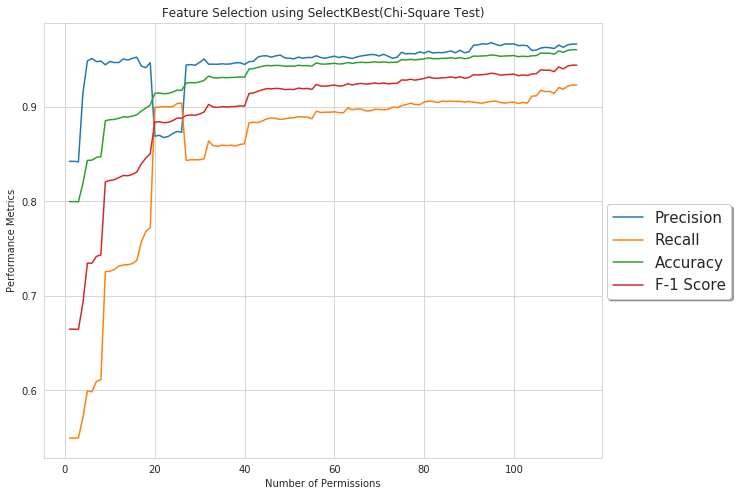

In [61]:
incremental_plot(1,115,title)

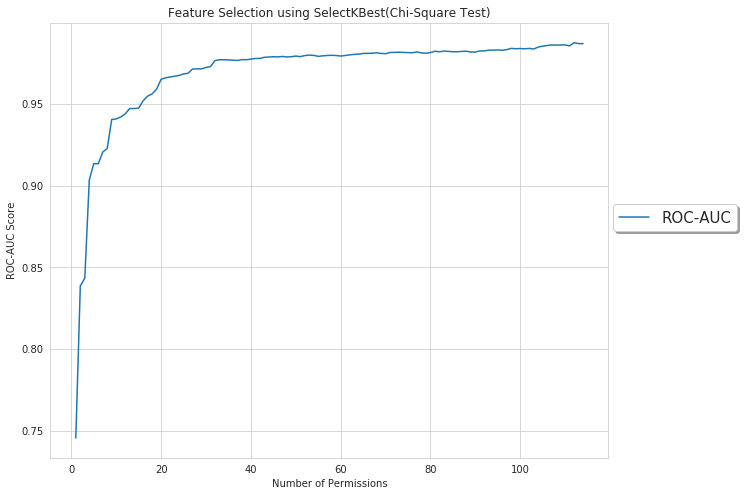

In [62]:
incremental_plot_auc(1,115,title)

In [63]:
#apply SelectKBest class to extract top 10 best features
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_train,y_train)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Permissions','Score']  #naming the dataframe columns

In [64]:
featureScores.Score.nlargest(5).index

Int64Index([0, 1, 3, 2, 4], dtype='int64')

In [65]:
clear_metrics()
#X_top_feat_imps
for index in range(1,115,1):
    top_permissions_indexes = []
    top_permissions_indexes = featureScores.Score.nlargest(index).index
    X_top_feat_imps = X_validate.iloc[0:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7997   (+/- 0.0213)
Precision: 0.8420   (+/- 0.0213)
Recall: 0.5496   (+/- 0.0213)
F-1 Score: 0.6647   (+/- 0.0213)
ROC-AUC: 0.8434   (+/- 0.0213)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8191   (+/- 0.0222)
Precision: 0.9147   (+/- 0.0222)
Recall: 0.5713   (+/- 0.0222)
F-1 Score: 0.6924   (+/- 0.0222)
ROC-AUC: 0.9035   (+/- 0.0222)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8434   (+/- 0.0243)
Precision: 0.9487   (+/- 0.0243)
Recall: 0.5996   (+

Classification Report for Random Forest:    39
Accuracy: 0.9319   (+/- 0.0211)
Precision: 0.9469   (+/- 0.0211)
Recall: 0.8603   (+/- 0.0211)
F-1 Score: 0.9013   (+/- 0.0211)
ROC-AUC: 0.9771   (+/- 0.0211)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9315   (+/- 0.0209)
Precision: 0.9450   (+/- 0.0209)
Recall: 0.8610   (+/- 0.0209)
F-1 Score: 0.9008   (+/- 0.0209)
ROC-AUC: 0.9774   (+/- 0.0209)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9401   (+/- 0.0209)
Precision: 0.9480   (+/- 0.0209)
Recall: 0.8831   (+/- 0.0209)
F-1 Score: 0.9142   (+/- 0.0209)
ROC-AUC: 0.9778   (+/- 0.0209)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9405   (+/- 0.0207)
Precision: 0.9483   (+/- 0.0207)
Recall: 0.8838   (+/- 0.0207)
F-1 Score: 0.9148   (+/- 0.0207)
ROC-AUC: 0.9779   (+/- 0.0207)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9420   (+/- 0.0199)
Precision: 0.9528   (+/- 0.0199)
Recall: 0.8835   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9504   (+/- 0.0201)
Precision: 0.9566   (+/- 0.0201)
Recall: 0.9040   (+/- 0.0201)
F-1 Score: 0.9294   (+/- 0.0201)
ROC-AUC: 0.9818   (+/- 0.0201)
(7518, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9497   (+/- 0.0188)
Precision: 0.9562   (+/- 0.0188)
Recall: 0.9026   (+/- 0.0188)
F-1 Score: 0.9284   (+/- 0.0188)
ROC-AUC: 0.9812   (+/- 0.0188)
(7518, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9504   (+/- 0.0188)
Precision: 0.9584   (+/- 0.0188)
Recall: 0.9022   (+/- 0.0188)
F-1 Score: 0.9292   (+/- 0.0188)
ROC-AUC: 0.9810   (+/- 0.0188)
(7518, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9509   (+/- 0.0199)
Precision: 0.9570   (+/- 0.0199)
Recall: 0.9051   (+/- 0.0199)
F-1 Score: 0.9302   (+/- 0.0199)
ROC-AUC: 0.9815   (+/- 0.0199)
(7518, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9520   (+/- 0.0158)
Precision: 0.9590   (+/- 0.0158)
Recall: 0.9062   (+/

In [66]:
title = "Feature Selection using SelectKBest(ANOVA F-value)"
results_to_csv(title)

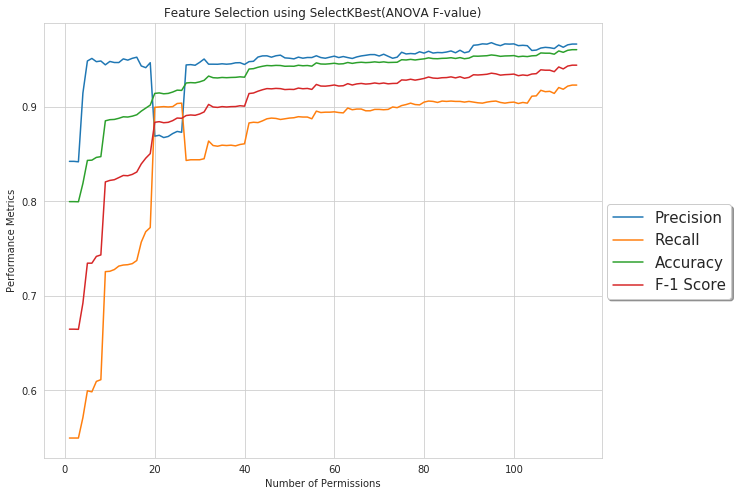

In [67]:
incremental_plot(1,115,title)

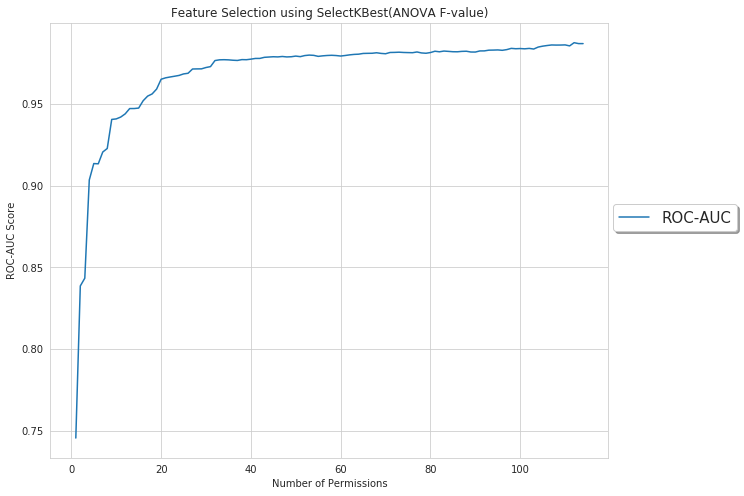

In [68]:
incremental_plot_auc(1,115,title)

In [69]:
X_top_feat_imps.shape

(7518, 113)

## Feature Importance (feature_importances_)

In [70]:
#RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_validate.columns)

In [71]:
clear_metrics()
#X_top_feat_imps
for index in range(1,115,1):
    top_permissions_indexes = []
    top_permissions_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8172   (+/- 0.0248)
Precision: 0.9381   (+/- 0.0248)
Recall: 0.5511   (+/- 0.0248)
F-1 Score: 0.6822   (+/- 0.0248)
ROC-AUC: 0.8998   (+/- 0.0248)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8387   (+/- 0.0244)
Precision: 0.9508   (+/- 0.0244)
Recall: 0.5842   (+/- 0.0244)
F-1 Score: 0.7235   (+/- 0.0244)
ROC-AUC: 0.9061   (+/- 0.0244)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8434   (+/- 0.0243)
Precision: 0.9487   (+/- 0.0243)
Recall: 0.5996   (+

Classification Report for Random Forest:    39
Accuracy: 0.9565   (+/- 0.0147)
Precision: 0.9609   (+/- 0.0147)
Recall: 0.9173   (+/- 0.0147)
F-1 Score: 0.9384   (+/- 0.0147)
ROC-AUC: 0.9844   (+/- 0.0147)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9566   (+/- 0.0147)
Precision: 0.9612   (+/- 0.0147)
Recall: 0.9173   (+/- 0.0147)
F-1 Score: 0.9386   (+/- 0.0147)
ROC-AUC: 0.9847   (+/- 0.0147)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9573   (+/- 0.0155)
Precision: 0.9641   (+/- 0.0155)
Recall: 0.9162   (+/- 0.0155)
F-1 Score: 0.9394   (+/- 0.0155)
ROC-AUC: 0.9855   (+/- 0.0155)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9576   (+/- 0.0159)
Precision: 0.9641   (+/- 0.0159)
Recall: 0.9169   (+/- 0.0159)
F-1 Score: 0.9398   (+/- 0.0159)
ROC-AUC: 0.9855   (+/- 0.0159)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9600   (+/- 0.0163)
Precision: 0.9687   (+/- 0.0163)
Recall: 0.9191   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9590   (+/- 0.0151)
Precision: 0.9639   (+/- 0.0151)
Recall: 0.9213   (+/- 0.0151)
F-1 Score: 0.9420   (+/- 0.0151)
ROC-AUC: 0.9873   (+/- 0.0151)
(7518, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9593   (+/- 0.0124)
Precision: 0.9643   (+/- 0.0124)
Recall: 0.9217   (+/- 0.0124)
F-1 Score: 0.9424   (+/- 0.0124)
ROC-AUC: 0.9873   (+/- 0.0124)
(7518, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9608   (+/- 0.0142)
Precision: 0.9666   (+/- 0.0142)
Recall: 0.9235   (+/- 0.0142)
F-1 Score: 0.9445   (+/- 0.0142)
ROC-AUC: 0.9872   (+/- 0.0142)
(7518, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9604   (+/- 0.0134)
Precision: 0.9666   (+/- 0.0134)
Recall: 0.9224   (+/- 0.0134)
F-1 Score: 0.9439   (+/- 0.0134)
ROC-AUC: 0.9873   (+/- 0.0134)
(7518, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9601   (+/- 0.0135)
Precision: 0.9669   (+/- 0.0135)
Recall: 0.9213   (+/

In [72]:
title = "Feature Selection using Random Forest Classifier - Feature Importances"
results_to_csv(title)

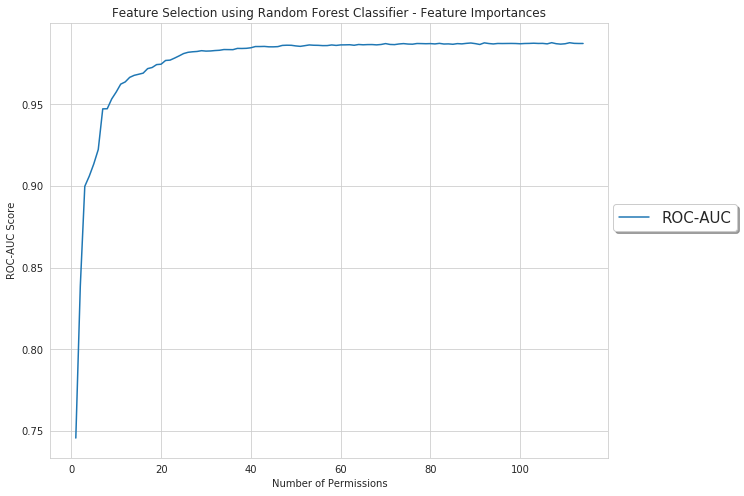

In [73]:
incremental_plot_auc(1,115, title)

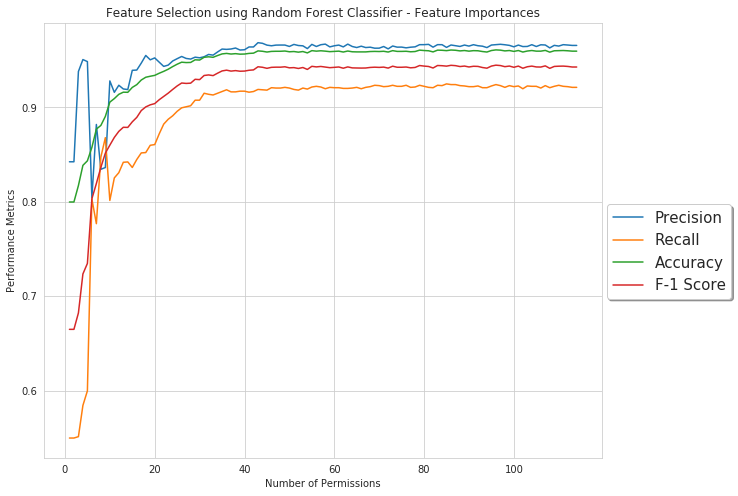

In [74]:
incremental_plot(1,115, title)


In [75]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)
model.fit(X_train,y_train)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)

In [76]:
clear_metrics()
X_top_feat_imps
for index in range(1,115,1):
    top_permissions_indexes = []
    top_permissions_indexes = feat_importances.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8172   (+/- 0.0248)
Precision: 0.9381   (+/- 0.0248)
Recall: 0.5511   (+/- 0.0248)
F-1 Score: 0.6822   (+/- 0.0248)
ROC-AUC: 0.8998   (+/- 0.0248)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8191   (+/- 0.0222)
Precision: 0.9147   (+/- 0.0222)
Recall: 0.5713   (+/- 0.0222)
F-1 Score: 0.6924   (+/- 0.0222)
ROC-AUC: 0.9035   (+/- 0.0222)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8434   (+/- 0.0243)
Precision: 0.9487   (+/- 0.0243)
Recall: 0.5996   (+

Classification Report for Random Forest:    39
Accuracy: 0.9573   (+/- 0.0152)
Precision: 0.9623   (+/- 0.0152)
Recall: 0.9180   (+/- 0.0152)
F-1 Score: 0.9395   (+/- 0.0152)
ROC-AUC: 0.9847   (+/- 0.0152)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9573   (+/- 0.0125)
Precision: 0.9623   (+/- 0.0125)
Recall: 0.9180   (+/- 0.0125)
F-1 Score: 0.9395   (+/- 0.0125)
ROC-AUC: 0.9848   (+/- 0.0125)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9584   (+/- 0.0146)
Precision: 0.9642   (+/- 0.0146)
Recall: 0.9191   (+/- 0.0146)
F-1 Score: 0.9410   (+/- 0.0146)
ROC-AUC: 0.9855   (+/- 0.0146)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9585   (+/- 0.0148)
Precision: 0.9647   (+/- 0.0148)
Recall: 0.9191   (+/- 0.0148)
F-1 Score: 0.9412   (+/- 0.0148)
ROC-AUC: 0.9854   (+/- 0.0148)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9570   (+/- 0.0139)
Precision: 0.9620   (+/- 0.0139)
Recall: 0.9176   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9597   (+/- 0.0128)
Precision: 0.9651   (+/- 0.0128)
Recall: 0.9221   (+/- 0.0128)
F-1 Score: 0.9430   (+/- 0.0128)
ROC-AUC: 0.9873   (+/- 0.0128)
(7518, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9598   (+/- 0.0142)
Precision: 0.9657   (+/- 0.0142)
Recall: 0.9217   (+/- 0.0142)
F-1 Score: 0.9431   (+/- 0.0142)
ROC-AUC: 0.9873   (+/- 0.0142)
(7518, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9604   (+/- 0.0151)
Precision: 0.9661   (+/- 0.0151)
Recall: 0.9228   (+/- 0.0151)
F-1 Score: 0.9439   (+/- 0.0151)
ROC-AUC: 0.9872   (+/- 0.0151)
(7518, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9614   (+/- 0.0156)
Precision: 0.9663   (+/- 0.0156)
Recall: 0.9257   (+/- 0.0156)
F-1 Score: 0.9455   (+/- 0.0156)
ROC-AUC: 0.9870   (+/- 0.0156)
(7518, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9593   (+/- 0.0128)
Precision: 0.9629   (+/- 0.0128)
Recall: 0.9232   (+/

In [77]:
title = "Feature Selection using Extra Trees Classifier Feature - Importances"
results_to_csv(title)

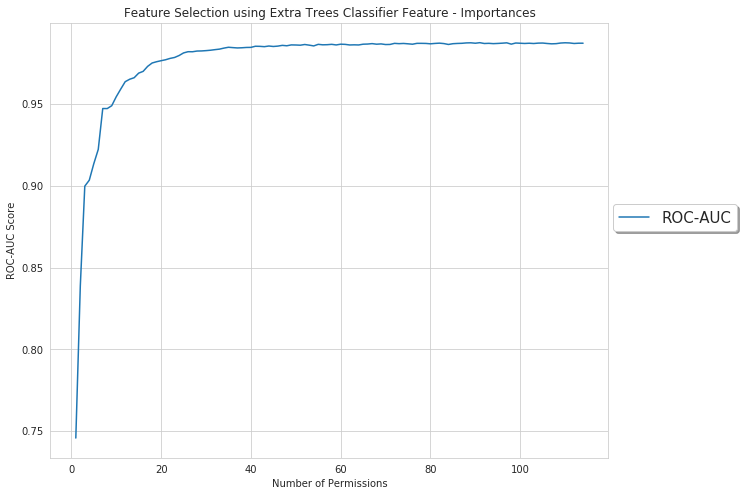

In [78]:
incremental_plot_auc(1,115, title)

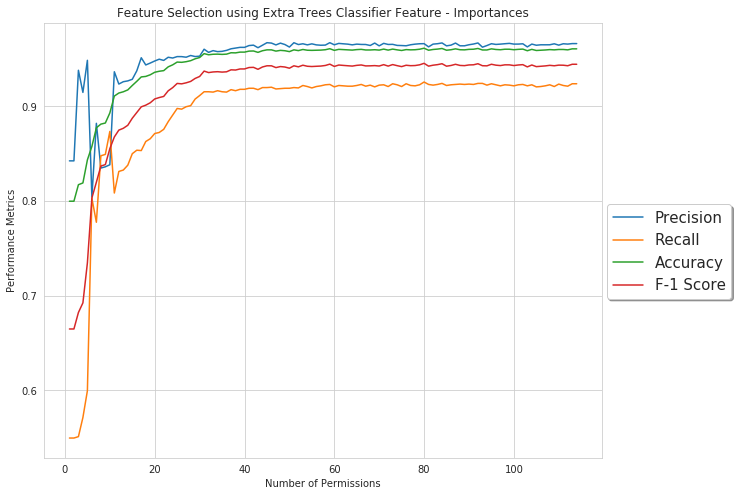

In [79]:
incremental_plot(1,115, title)


## Feature Selection Based on Mutual Information (Entropy) Gain

In [80]:
from sklearn.feature_selection import mutual_info_classif

In [81]:
mi = mutual_info_classif(X_train, y_train)

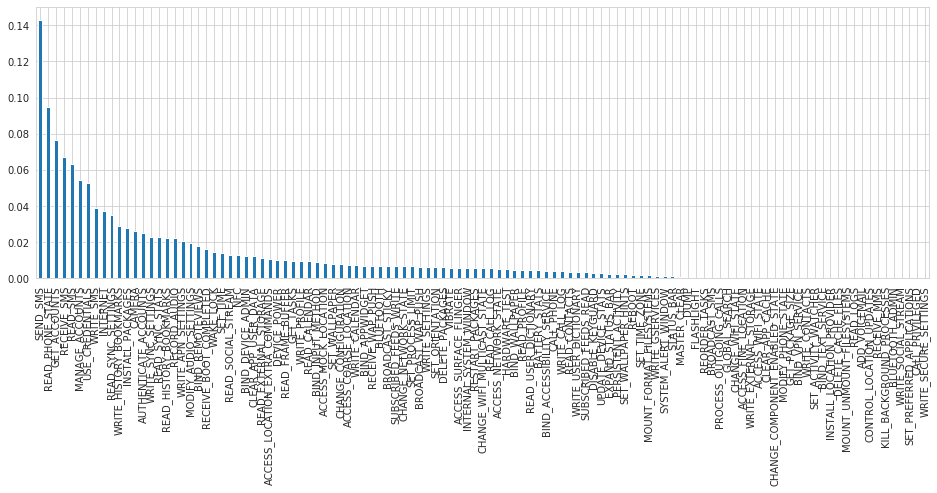

In [82]:
mi = pd.Series(mi)
mi.index = X_train.columns
mi.sort_values(ascending=False, inplace = True)
mi.plot.bar(figsize = (16,5))

In [83]:
clear_metrics()
for index in range(1, 115,1):
    top_permissions_indexes = []
    top_permissions_indexes = mi.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.8172   (+/- 0.0248)
Precision: 0.9381   (+/- 0.0248)
Recall: 0.5511   (+/- 0.0248)
F-1 Score: 0.6822   (+/- 0.0248)
ROC-AUC: 0.8998   (+/- 0.0248)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8191   (+/- 0.0222)
Precision: 0.9147   (+/- 0.0222)
Recall: 0.5713   (+/- 0.0222)
F-1 Score: 0.6924   (+/- 0.0222)
ROC-AUC: 0.9035   (+/- 0.0222)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8434   (+/- 0.0243)
Precision: 0.9487   (+/- 0.0243)
Recall: 0.5996   (+

Classification Report for Random Forest:    39
Accuracy: 0.9343   (+/- 0.0165)
Precision: 0.9439   (+/- 0.0165)
Recall: 0.8702   (+/- 0.0165)
F-1 Score: 0.9054   (+/- 0.0165)
ROC-AUC: 0.9743   (+/- 0.0165)
(7518, 40)
Classification Report for Random Forest:    40
Accuracy: 0.9356   (+/- 0.0189)
Precision: 0.9471   (+/- 0.0189)
Recall: 0.8710   (+/- 0.0189)
F-1 Score: 0.9072   (+/- 0.0189)
ROC-AUC: 0.9752   (+/- 0.0189)
(7518, 41)
Classification Report for Random Forest:    41
Accuracy: 0.9355   (+/- 0.0183)
Precision: 0.9474   (+/- 0.0183)
Recall: 0.8702   (+/- 0.0183)
F-1 Score: 0.9069   (+/- 0.0183)
ROC-AUC: 0.9751   (+/- 0.0183)
(7518, 42)
Classification Report for Random Forest:    42
Accuracy: 0.9363   (+/- 0.0177)
Precision: 0.9490   (+/- 0.0177)
Recall: 0.8710   (+/- 0.0177)
F-1 Score: 0.9081   (+/- 0.0177)
ROC-AUC: 0.9753   (+/- 0.0177)
(7518, 43)
Classification Report for Random Forest:    43
Accuracy: 0.9362   (+/- 0.0201)
Precision: 0.9482   (+/- 0.0201)
Recall: 0.8713   (+/

Classification Report for Random Forest:    77
Accuracy: 0.9501   (+/- 0.0187)
Precision: 0.9513   (+/- 0.0187)
Recall: 0.9088   (+/- 0.0187)
F-1 Score: 0.9294   (+/- 0.0187)
ROC-AUC: 0.9822   (+/- 0.0187)
(7518, 78)
Classification Report for Random Forest:    78
Accuracy: 0.9500   (+/- 0.0180)
Precision: 0.9503   (+/- 0.0180)
Recall: 0.9096   (+/- 0.0180)
F-1 Score: 0.9293   (+/- 0.0180)
ROC-AUC: 0.9823   (+/- 0.0180)
(7518, 79)
Classification Report for Random Forest:    79
Accuracy: 0.9505   (+/- 0.0162)
Precision: 0.9507   (+/- 0.0162)
Recall: 0.9107   (+/- 0.0162)
F-1 Score: 0.9301   (+/- 0.0162)
ROC-AUC: 0.9827   (+/- 0.0162)
(7518, 80)
Classification Report for Random Forest:    80
Accuracy: 0.9497   (+/- 0.0174)
Precision: 0.9501   (+/- 0.0174)
Recall: 0.9088   (+/- 0.0174)
F-1 Score: 0.9289   (+/- 0.0174)
ROC-AUC: 0.9826   (+/- 0.0174)
(7518, 81)
Classification Report for Random Forest:    81
Accuracy: 0.9504   (+/- 0.0154)
Precision: 0.9520   (+/- 0.0154)
Recall: 0.9088   (+/

In [84]:
title = "Feature Selection using Mutual Information Gain (Entropy)"
results_to_csv(title)

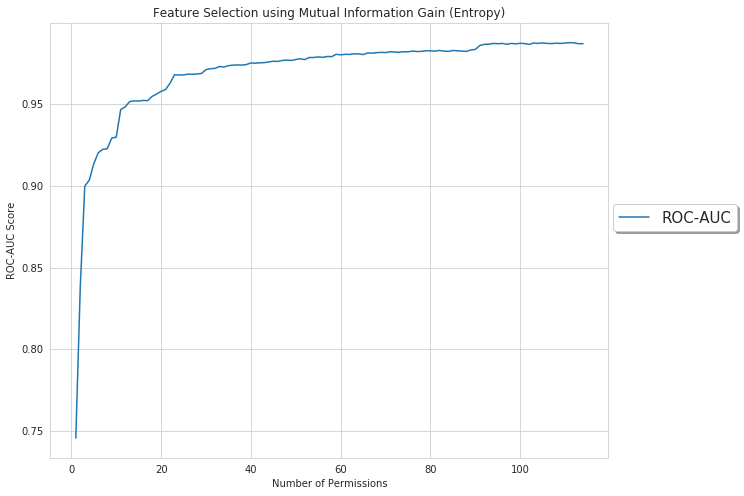

In [85]:
incremental_plot_auc(1,115, title)

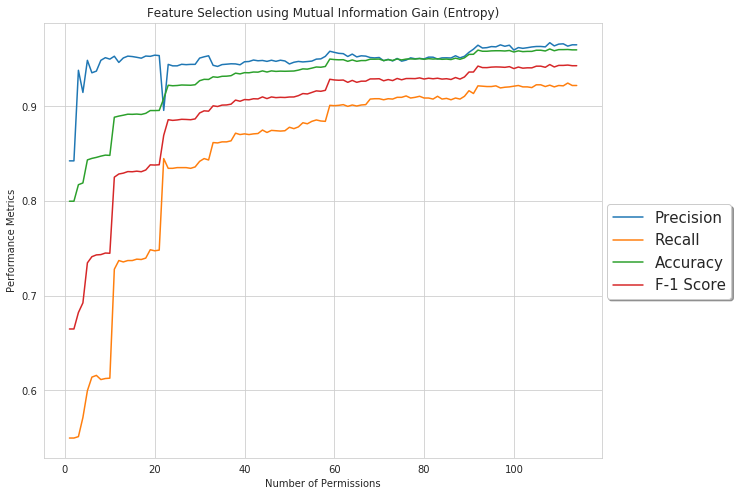

In [86]:
incremental_plot(1,115, title)


In [262]:
top_permissions_indexes = mi.nlargest(30).index
X_top_feat_imps = X.loc[:,top_permissions_indexes ]
print(X_top_feat_imps.shape)
run_randomForest(X_top_feat_imps,y_all, index)

(15036, 30)
Classification Report for Random Forest:    31
Accuracy: 0.9464   (+/- 0.0114)
Precision: 0.9571   (+/- 0.0114)
Recall: 0.8953   (+/- 0.0114)
F-1 Score: 0.9251   (+/- 0.0114)
ROC-AUC: 0.9863   (+/- 0.0114)


## Feature Selection Based on Univariate ROC_AUC for Classification

In [87]:
from sklearn.metrics import roc_auc_score

roc_auc = []
for feature in X_train.columns:
    clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    clf.fit(X_train[feature].to_frame(), y_train)
    y_pred = clf.predict(X_validate[feature].to_frame())
    roc_auc.append(roc_auc_score(y_validate, y_pred))

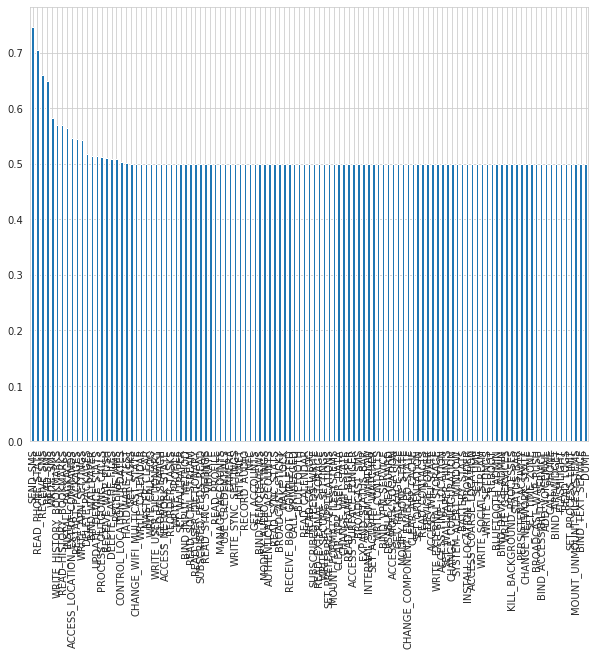

In [88]:
roc_values = pd.Series(roc_auc)
roc_values.index = X_train.columns
roc_values.sort_values(ascending =False, inplace = True)
roc_values.plot.bar()

In [89]:
sel = roc_values[roc_values>0.5]
X_roc_auc = X_train[sel.index]
X_roc_auc.shape

(7518, 20)

In [90]:
clear_metrics()
for index in range(1, len(sel)):
    top_permissions_indexes = []
    top_permissions_indexes = sel.nlargest(index).index
    X_top_feat_imps = X_validate.loc[:,top_permissions_indexes ]
    print(X_top_feat_imps.shape)
    run_randomForest(X_top_feat_imps,y_validate, index)

(7518, 1)
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Classification Report for Random Forest:    3
Accuracy: 0.7997   (+/- 0.0213)
Precision: 0.8420   (+/- 0.0213)
Recall: 0.5496   (+/- 0.0213)
F-1 Score: 0.6647   (+/- 0.0213)
ROC-AUC: 0.8434   (+/- 0.0213)
(7518, 4)
Classification Report for Random Forest:    4
Accuracy: 0.8136   (+/- 0.0222)
Precision: 0.8221   (+/- 0.0222)
Recall: 0.6191   (+/- 0.0222)
F-1 Score: 0.7061   (+/- 0.0222)
ROC-AUC: 0.8542   (+/- 0.0222)
(7518, 5)
Classification Report for Random Forest:    5
Accuracy: 0.8138   (+/- 0.0208)
Precision: 0.8364   (+/- 0.0208)
Recall: 0.6037   (+

In [91]:
top_permissions_indexes = []
top_permissions_indexes = sel.nlargest(30).index
X_top_feat_imps = X.loc[:,top_permissions_indexes ]
print(X_top_feat_imps.shape)


NameError: name 'X' is not defined

In [ ]:
%%time 
run_randomForest(X_top_feat_imps,y_all, index)

In [92]:
title = "Feature Selection Based on Univariate ROC_AUC Score"
results_to_csv(title)

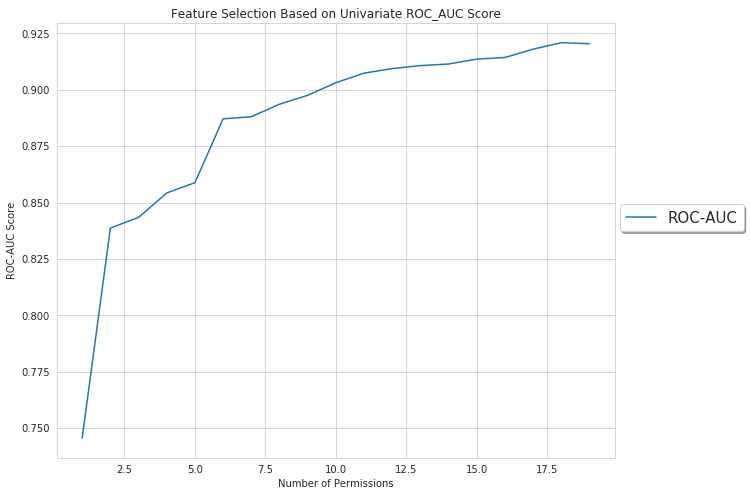

In [93]:
incremental_plot_auc(1,len(sel), title)

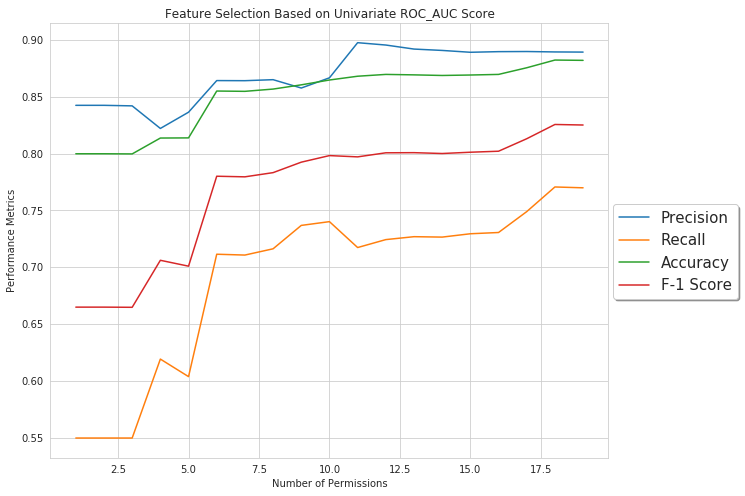

In [94]:
incremental_plot(1,len(sel), title)


## Feature Selection using Principal Component Analysis

In [95]:
clear_metrics()
for component in range(1,114):
    pca = PCA(n_components=component, random_state=0)
    pca.fit(X_train)
    X_pca_optimal = pca.transform(X_validate)
    print('Selected Components: ', component)
    run_randomForest(X_pca_optimal,y_validate,component)
    print()

Selected Components:  1
Classification Report for Random Forest:    1
Accuracy: 0.8868   (+/- 0.0314)
Precision: 0.8492   (+/- 0.0314)
Recall: 0.8360   (+/- 0.0314)
F-1 Score: 0.8424   (+/- 0.0314)
ROC-AUC: 0.9135   (+/- 0.0314)

Selected Components:  2
Classification Report for Random Forest:    2
Accuracy: 0.9211   (+/- 0.0240)
Precision: 0.9120   (+/- 0.0240)
Recall: 0.8658   (+/- 0.0240)
F-1 Score: 0.8880   (+/- 0.0240)
ROC-AUC: 0.9647   (+/- 0.0240)

Selected Components:  3
Classification Report for Random Forest:    3
Accuracy: 0.9399   (+/- 0.0172)
Precision: 0.9373   (+/- 0.0172)
Recall: 0.8938   (+/- 0.0172)
F-1 Score: 0.9149   (+/- 0.0172)
ROC-AUC: 0.9784   (+/- 0.0172)

Selected Components:  4
Classification Report for Random Forest:    4
Accuracy: 0.9465   (+/- 0.0163)
Precision: 0.9426   (+/- 0.0163)
Recall: 0.9077   (+/- 0.0163)
F-1 Score: 0.9247   (+/- 0.0163)
ROC-AUC: 0.9828   (+/- 0.0163)

Selected Components:  5
Classification Report for Random Forest:    5
Accuracy: 

Classification Report for Random Forest:    37
Accuracy: 0.9557   (+/- 0.0165)
Precision: 0.9709   (+/- 0.0165)
Recall: 0.9048   (+/- 0.0165)
F-1 Score: 0.9365   (+/- 0.0165)
ROC-AUC: 0.9842   (+/- 0.0165)

Selected Components:  38
Classification Report for Random Forest:    38
Accuracy: 0.9564   (+/- 0.0171)
Precision: 0.9732   (+/- 0.0171)
Recall: 0.9044   (+/- 0.0171)
F-1 Score: 0.9373   (+/- 0.0171)
ROC-AUC: 0.9838   (+/- 0.0171)

Selected Components:  39
Classification Report for Random Forest:    39
Accuracy: 0.9560   (+/- 0.0164)
Precision: 0.9702   (+/- 0.0164)
Recall: 0.9062   (+/- 0.0164)
F-1 Score: 0.9370   (+/- 0.0164)
ROC-AUC: 0.9839   (+/- 0.0164)

Selected Components:  40
Classification Report for Random Forest:    40
Accuracy: 0.9561   (+/- 0.0184)
Precision: 0.9728   (+/- 0.0184)
Recall: 0.9040   (+/- 0.0184)
F-1 Score: 0.9369   (+/- 0.0184)
ROC-AUC: 0.9839   (+/- 0.0184)

Selected Components:  41
Classification Report for Random Forest:    41
Accuracy: 0.9554   (+/- 0

Classification Report for Random Forest:    73
Accuracy: 0.9550   (+/- 0.0147)
Precision: 0.9749   (+/- 0.0147)
Recall: 0.8989   (+/- 0.0147)
F-1 Score: 0.9352   (+/- 0.0147)
ROC-AUC: 0.9835   (+/- 0.0147)

Selected Components:  74
Classification Report for Random Forest:    74
Accuracy: 0.9554   (+/- 0.0147)
Precision: 0.9747   (+/- 0.0147)
Recall: 0.9004   (+/- 0.0147)
F-1 Score: 0.9359   (+/- 0.0147)
ROC-AUC: 0.9831   (+/- 0.0147)

Selected Components:  75
Classification Report for Random Forest:    75
Accuracy: 0.9553   (+/- 0.0146)
Precision: 0.9757   (+/- 0.0146)
Recall: 0.8989   (+/- 0.0146)
F-1 Score: 0.9356   (+/- 0.0146)
ROC-AUC: 0.9838   (+/- 0.0146)

Selected Components:  76
Classification Report for Random Forest:    76
Accuracy: 0.9557   (+/- 0.0136)
Precision: 0.9777   (+/- 0.0136)
Recall: 0.8982   (+/- 0.0136)
F-1 Score: 0.9361   (+/- 0.0136)
ROC-AUC: 0.9835   (+/- 0.0136)

Selected Components:  77
Classification Report for Random Forest:    77
Accuracy: 0.9545   (+/- 0

Classification Report for Random Forest:    109
Accuracy: 0.9537   (+/- 0.0133)
Precision: 0.9764   (+/- 0.0133)
Recall: 0.8937   (+/- 0.0133)
F-1 Score: 0.9331   (+/- 0.0133)
ROC-AUC: 0.9828   (+/- 0.0133)

Selected Components:  110
Classification Report for Random Forest:    110
Accuracy: 0.9540   (+/- 0.0137)
Precision: 0.9787   (+/- 0.0137)
Recall: 0.8923   (+/- 0.0137)
F-1 Score: 0.9334   (+/- 0.0137)
ROC-AUC: 0.9830   (+/- 0.0137)

Selected Components:  111
Classification Report for Random Forest:    111
Accuracy: 0.9540   (+/- 0.0156)
Precision: 0.9768   (+/- 0.0156)
Recall: 0.8941   (+/- 0.0156)
F-1 Score: 0.9335   (+/- 0.0156)
ROC-AUC: 0.9832   (+/- 0.0156)

Selected Components:  112
Classification Report for Random Forest:    112
Accuracy: 0.9536   (+/- 0.0159)
Precision: 0.9764   (+/- 0.0159)
Recall: 0.8934   (+/- 0.0159)
F-1 Score: 0.9329   (+/- 0.0159)
ROC-AUC: 0.9835   (+/- 0.0159)

Selected Components:  113
Classification Report for Random Forest:    113
Accuracy: 0.9545

ValueError: n_components=114 must be between 0 and min(n_samples, n_features)=113 with svd_solver='full'

In [96]:
title = "Feature Selection using Principal Component Analysis"
results_to_csv(title)

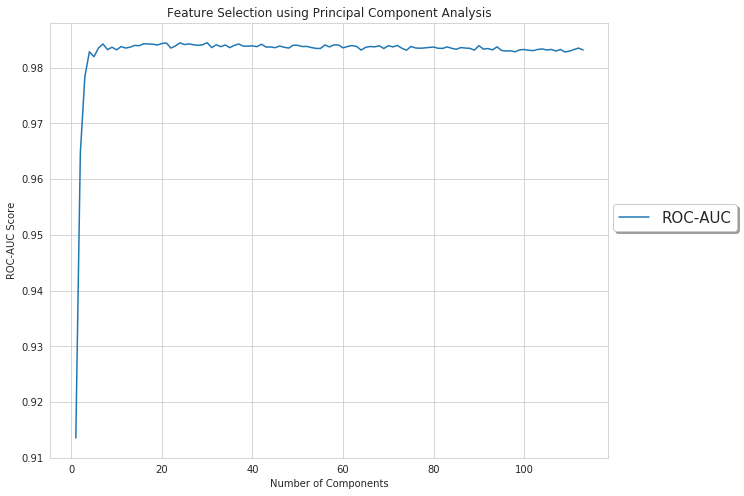

In [99]:
incremental_plot_auc(1,114, title, "Number of Components")

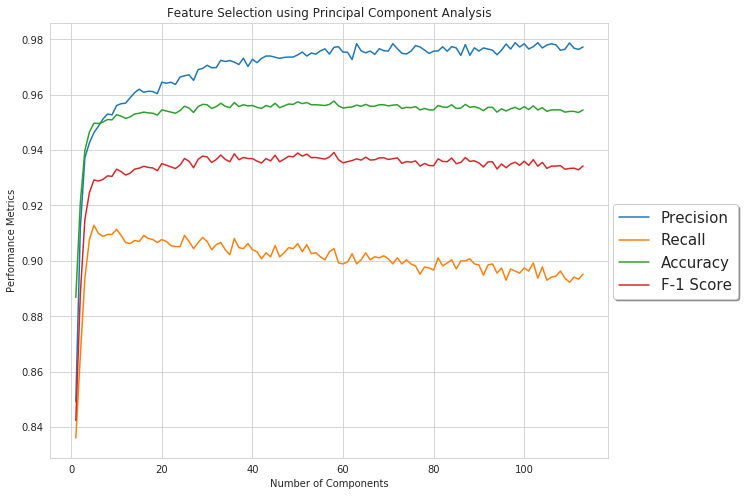

In [100]:
incremental_plot(1,114, title, "Number of Components")


## Feature Selection using RFE (RandomForestClassifier)

In [101]:
#best RFE(RandomForestClassifier) features
clear_metrics()
for index in range(1, 115):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
    print(X_transform.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_transform, y_validate, index)

(7518, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.8387   (+/- 0.0216)
(7518, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8172   (+/- 0.0248)
Precision: 0.9381   (+/- 0.0248)
Recall: 0.5511   (+/- 0.0248)
F-1 Score: 0.6822   (+/- 0.0248)
ROC-AUC: 0.8998   (+/- 0.0248)
(7518, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8557   (+/- 0.0155)
Precision: 0.9406   (+/- 0.0155)
Recall: 0.6419   (+/- 0.0155)
F-1 Score: 0.7627   (+/- 0.0155)
ROC-AUC: 0.9202   (+/- 0.0155)
(7518, 5)
Selected Feature:  5
Classification Report for

(7518, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9572   (+/- 0.0157)
Precision: 0.9609   (+/- 0.0157)
Recall: 0.9191   (+/- 0.0157)
F-1 Score: 0.9394   (+/- 0.0157)
ROC-AUC: 0.9839   (+/- 0.0157)
(7518, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9574   (+/- 0.0144)
Precision: 0.9637   (+/- 0.0144)
Recall: 0.9169   (+/- 0.0144)
F-1 Score: 0.9396   (+/- 0.0144)
ROC-AUC: 0.9840   (+/- 0.0144)
(7518, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9584   (+/- 0.0156)
Precision: 0.9628   (+/- 0.0156)
Recall: 0.9206   (+/- 0.0156)
F-1 Score: 0.9411   (+/- 0.0156)
ROC-AUC: 0.9842   (+/- 0.0156)
(7518, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9589   (+/- 0.0170)
Precision: 0.9646   (+/- 0.0170)
Recall: 0.9202   (+/- 0.0170)
F-1 Score: 0.9418   (+/- 0.0170)
ROC-AUC: 0.9851   (+/- 0.0170)
(7518, 40)
Selected Feature:  40
Classificat

(7518, 71)
Selected Feature:  71
Classification Report for Random Forest:    71
Accuracy: 0.9588   (+/- 0.0152)
Precision: 0.9628   (+/- 0.0152)
Recall: 0.9217   (+/- 0.0152)
F-1 Score: 0.9417   (+/- 0.0152)
ROC-AUC: 0.9873   (+/- 0.0152)
(7518, 72)
Selected Feature:  72
Classification Report for Random Forest:    72
Accuracy: 0.9592   (+/- 0.0145)
Precision: 0.9643   (+/- 0.0145)
Recall: 0.9213   (+/- 0.0145)
F-1 Score: 0.9422   (+/- 0.0145)
ROC-AUC: 0.9868   (+/- 0.0145)
(7518, 73)
Selected Feature:  73
Classification Report for Random Forest:    73
Accuracy: 0.9597   (+/- 0.0147)
Precision: 0.9647   (+/- 0.0147)
Recall: 0.9224   (+/- 0.0147)
F-1 Score: 0.9430   (+/- 0.0147)
ROC-AUC: 0.9869   (+/- 0.0147)
(7518, 74)
Selected Feature:  74
Classification Report for Random Forest:    74
Accuracy: 0.9600   (+/- 0.0140)
Precision: 0.9661   (+/- 0.0140)
Recall: 0.9217   (+/- 0.0140)
F-1 Score: 0.9433   (+/- 0.0140)
ROC-AUC: 0.9872   (+/- 0.0140)
(7518, 75)
Selected Feature:  75
Classificat

(7518, 106)
Selected Feature:  106
Classification Report for Random Forest:    106
Accuracy: 0.9596   (+/- 0.0133)
Precision: 0.9629   (+/- 0.0133)
Recall: 0.9239   (+/- 0.0133)
F-1 Score: 0.9429   (+/- 0.0133)
ROC-AUC: 0.9875   (+/- 0.0133)
(7518, 107)
Selected Feature:  107
Classification Report for Random Forest:    107
Accuracy: 0.9604   (+/- 0.0131)
Precision: 0.9665   (+/- 0.0131)
Recall: 0.9224   (+/- 0.0131)
F-1 Score: 0.9439   (+/- 0.0131)
ROC-AUC: 0.9872   (+/- 0.0131)
(7518, 108)
Selected Feature:  108
Classification Report for Random Forest:    108
Accuracy: 0.9594   (+/- 0.0140)
Precision: 0.9643   (+/- 0.0140)
Recall: 0.9221   (+/- 0.0140)
F-1 Score: 0.9426   (+/- 0.0140)
ROC-AUC: 0.9874   (+/- 0.0140)
(7518, 109)
Selected Feature:  109
Classification Report for Random Forest:    109
Accuracy: 0.9600   (+/- 0.0129)
Precision: 0.9647   (+/- 0.0129)
Recall: 0.9232   (+/- 0.0129)
F-1 Score: 0.9434   (+/- 0.0129)
ROC-AUC: 0.9874   (+/- 0.0129)
(7518, 110)
Selected Feature:  1

In [102]:
title = "Recursive Feature Elimination (RFE) using Random Forest Classifier"
results_to_csv(title)

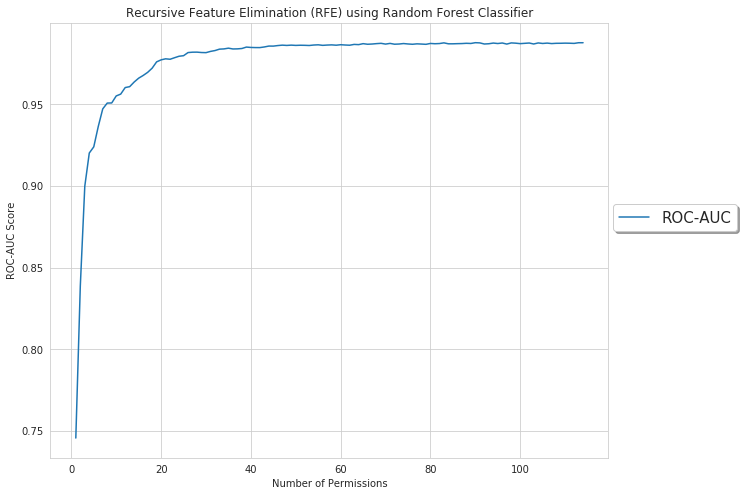

In [103]:
incremental_plot_auc(1,115, title)

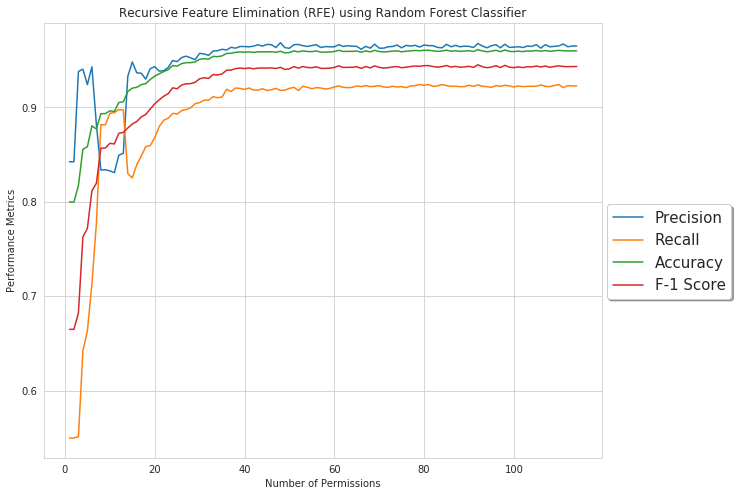

In [104]:
incremental_plot(1,115, title)


In [105]:
#best RFE(Gradient BoostingClassifier) features
clear_metrics()
for index in range(1, 115):
    sel = RFE(GradientBoostingClassifier(n_estimators=100, random_state=0), n_features_to_select = index)
    sel.fit(X_train,y_train)
    X_optimal_gradient = sel.transform(X_validate)
    print(X_optimal_gradient.shape)
    print('Selected Feature: ', index)
    run_randomForest(X_optimal_gradient,y_validate, index)

(7518, 1)
Selected Feature:  1
Classification Report for Random Forest:    1
Accuracy: 0.7998   (+/- 0.0216)
Precision: 0.8424   (+/- 0.0216)
Recall: 0.5496   (+/- 0.0216)
F-1 Score: 0.6648   (+/- 0.0216)
ROC-AUC: 0.7456   (+/- 0.0216)
(7518, 2)
Selected Feature:  2
Classification Report for Random Forest:    2
Accuracy: 0.8203   (+/- 0.0226)
Precision: 0.9671   (+/- 0.0226)
Recall: 0.5210   (+/- 0.0226)
F-1 Score: 0.6768   (+/- 0.0226)
ROC-AUC: 0.8226   (+/- 0.0226)
(7518, 3)
Selected Feature:  3
Classification Report for Random Forest:    3
Accuracy: 0.8172   (+/- 0.0248)
Precision: 0.9381   (+/- 0.0248)
Recall: 0.5511   (+/- 0.0248)
F-1 Score: 0.6822   (+/- 0.0248)
ROC-AUC: 0.8998   (+/- 0.0248)
(7518, 4)
Selected Feature:  4
Classification Report for Random Forest:    4
Accuracy: 0.8557   (+/- 0.0155)
Precision: 0.9406   (+/- 0.0155)
Recall: 0.6419   (+/- 0.0155)
F-1 Score: 0.7627   (+/- 0.0155)
ROC-AUC: 0.9202   (+/- 0.0155)
(7518, 5)
Selected Feature:  5
Classification Report for

(7518, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9421   (+/- 0.0246)
Precision: 0.9431   (+/- 0.0246)
Recall: 0.8949   (+/- 0.0246)
F-1 Score: 0.9180   (+/- 0.0246)
ROC-AUC: 0.9824   (+/- 0.0246)
(7518, 37)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9408   (+/- 0.0178)
Precision: 0.9388   (+/- 0.0178)
Recall: 0.8952   (+/- 0.0178)
F-1 Score: 0.9162   (+/- 0.0178)
ROC-AUC: 0.9828   (+/- 0.0178)
(7518, 38)
Selected Feature:  38
Classification Report for Random Forest:    38
Accuracy: 0.9401   (+/- 0.0193)
Precision: 0.9402   (+/- 0.0193)
Recall: 0.8919   (+/- 0.0193)
F-1 Score: 0.9151   (+/- 0.0193)
ROC-AUC: 0.9825   (+/- 0.0193)
(7518, 39)
Selected Feature:  39
Classification Report for Random Forest:    39
Accuracy: 0.9479   (+/- 0.0190)
Precision: 0.9532   (+/- 0.0190)
Recall: 0.9004   (+/- 0.0190)
F-1 Score: 0.9259   (+/- 0.0190)
ROC-AUC: 0.9837   (+/- 0.0190)
(7518, 40)
Selected Feature:  40
Classificat

(7518, 71)
Selected Feature:  71
Classification Report for Random Forest:    71
Accuracy: 0.9606   (+/- 0.0144)
Precision: 0.9651   (+/- 0.0144)
Recall: 0.9246   (+/- 0.0144)
F-1 Score: 0.9444   (+/- 0.0144)
ROC-AUC: 0.9863   (+/- 0.0144)
(7518, 72)
Selected Feature:  72
Classification Report for Random Forest:    72
Accuracy: 0.9612   (+/- 0.0143)
Precision: 0.9670   (+/- 0.0143)
Recall: 0.9243   (+/- 0.0143)
F-1 Score: 0.9451   (+/- 0.0143)
ROC-AUC: 0.9865   (+/- 0.0143)
(7518, 73)
Selected Feature:  73
Classification Report for Random Forest:    73
Accuracy: 0.9605   (+/- 0.0147)
Precision: 0.9659   (+/- 0.0147)
Recall: 0.9235   (+/- 0.0147)
F-1 Score: 0.9441   (+/- 0.0147)
ROC-AUC: 0.9865   (+/- 0.0147)
(7518, 74)
Selected Feature:  74
Classification Report for Random Forest:    74
Accuracy: 0.9602   (+/- 0.0143)
Precision: 0.9640   (+/- 0.0143)
Recall: 0.9246   (+/- 0.0143)
F-1 Score: 0.9438   (+/- 0.0143)
ROC-AUC: 0.9868   (+/- 0.0143)
(7518, 75)
Selected Feature:  75
Classificat

(7518, 106)
Selected Feature:  106
Classification Report for Random Forest:    106
Accuracy: 0.9601   (+/- 0.0139)
Precision: 0.9640   (+/- 0.0139)
Recall: 0.9243   (+/- 0.0139)
F-1 Score: 0.9436   (+/- 0.0139)
ROC-AUC: 0.9872   (+/- 0.0139)
(7518, 107)
Selected Feature:  107
Classification Report for Random Forest:    107
Accuracy: 0.9605   (+/- 0.0142)
Precision: 0.9658   (+/- 0.0142)
Recall: 0.9235   (+/- 0.0142)
F-1 Score: 0.9441   (+/- 0.0142)
ROC-AUC: 0.9873   (+/- 0.0142)
(7518, 108)
Selected Feature:  108
Classification Report for Random Forest:    108
Accuracy: 0.9614   (+/- 0.0133)
Precision: 0.9674   (+/- 0.0133)
Recall: 0.9246   (+/- 0.0133)
F-1 Score: 0.9454   (+/- 0.0133)
ROC-AUC: 0.9872   (+/- 0.0133)
(7518, 109)
Selected Feature:  109
Classification Report for Random Forest:    109
Accuracy: 0.9593   (+/- 0.0129)
Precision: 0.9643   (+/- 0.0129)
Recall: 0.9217   (+/- 0.0129)
F-1 Score: 0.9424   (+/- 0.0129)
ROC-AUC: 0.9870   (+/- 0.0129)
(7518, 110)
Selected Feature:  1

In [106]:
title = "Recursive Feature Elimination (RFE) using Gradient Boosting Classifier"
results_to_csv(title)

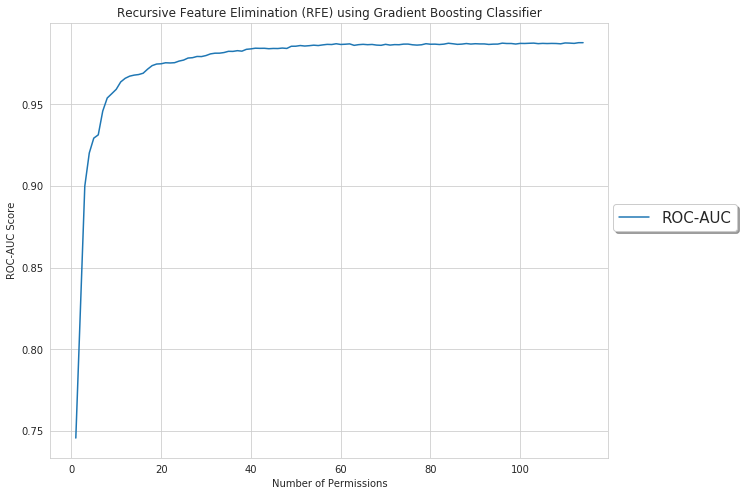

In [107]:
incremental_plot_auc(1,115, title)

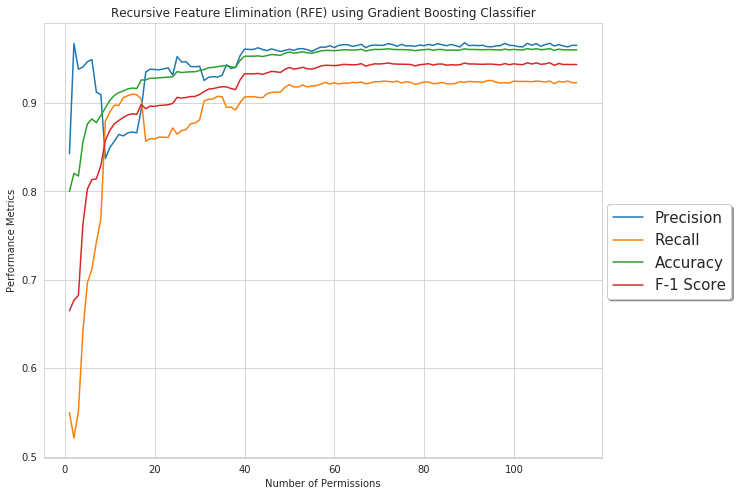

In [108]:
incremental_plot(1,115, title)


# Classifiers Evaluation

## For All Features

In [34]:
start = time.time()
run_randomForest(X_all, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9891   (+/- 0.0055)
Precision: 0.9931   (+/- 0.0055)
Recall: 0.9773   (+/- 0.0055)
F-1 Score: 0.9851   (+/- 0.0055)
ROC-AUC: 0.9988   (+/- 0.0055)
7.318322658538818


In [109]:
%%time
run_randomForest(X_all, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9891   (+/- 0.0055)
Precision: 0.9931   (+/- 0.0055)
Recall: 0.9773   (+/- 0.0055)
F-1 Score: 0.9851   (+/- 0.0055)
ROC-AUC: 0.9988   (+/- 0.0055)
CPU times: user 76.1 ms, sys: 68.2 ms, total: 144 ms
Wall time: 9 s


## For All Permissions

In [35]:
start = time.time()
run_randomForest(X_permissions, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9648   (+/- 0.0056)
Precision: 0.9703   (+/- 0.0056)
Recall: 0.9333   (+/- 0.0056)
F-1 Score: 0.9514   (+/- 0.0056)
ROC-AUC: 0.9911   (+/- 0.0056)
7.59743332862854


In [17]:
%%time
run_randomForest(X_permissions, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9648   (+/- 0.0056)
Precision: 0.9703   (+/- 0.0056)
Recall: 0.9333   (+/- 0.0056)
F-1 Score: 0.9514   (+/- 0.0056)
ROC-AUC: 0.9911   (+/- 0.0056)
CPU times: user 54.8 ms, sys: 41.5 ms, total: 96.3 ms
Wall time: 8.4 s


## For All API Calls

In [33]:
start = time.time()
run_randomForest(X_apis, y_all)
end = time.time()
print(end - start)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
5.439223051071167


In [50]:
%%time
run_randomForest(X_apis, y_all)

Classification Report for Random Forest:    0
Accuracy: 0.9808   (+/- 0.0076)
Precision: 0.9862   (+/- 0.0076)
Recall: 0.9617   (+/- 0.0076)
F-1 Score: 0.9738   (+/- 0.0076)
ROC-AUC: 0.9963   (+/- 0.0076)
CPU times: user 66.3 ms, sys: 7.84 ms, total: 74.2 ms
Wall time: 6.31 s


## Recursive Feature Elimination (RFE) using Random Forest Classifier

### Significant Permissions Identification

In [18]:
clear_metrics()

In [19]:
index =38

In [23]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X_permissions, y_all, test_size = 0.5, random_state = 0)


In [18]:
import time

clear_metrics()
#X_top_feat_imps
for index in range(34,41,1):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
    print(X_transform.shape)
    print('Selected Feature: ', index)
    start = time.time()
    run_randomForest(X_transform, y_validate, index)
    end = time.time()
    print(end - start)

(7518, 34)
Selected Feature:  34
Classification Report for Random Forest:    34
Accuracy: 0.9538   (+/- 0.0169)
Precision: 0.9601   (+/- 0.0169)
Recall: 0.9103   (+/- 0.0169)
F-1 Score: 0.9344   (+/- 0.0169)
ROC-AUC: 0.9839   (+/- 0.0169)
3.3596932888031006
(7518, 35)
Selected Feature:  35
Classification Report for Random Forest:    35
Accuracy: 0.9546   (+/- 0.0183)
Precision: 0.9616   (+/- 0.0183)
Recall: 0.9110   (+/- 0.0183)
F-1 Score: 0.9355   (+/- 0.0183)
ROC-AUC: 0.9844   (+/- 0.0183)
1.222684621810913
(7518, 36)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9572   (+/- 0.0157)
Precision: 0.9609   (+/- 0.0157)
Recall: 0.9191   (+/- 0.0157)
F-1 Score: 0.9394   (+/- 0.0157)
ROC-AUC: 0.9839   (+/- 0.0157)
1.2467279434204102


KeyboardInterrupt: 

In [ ]:
title = "RFE using Random Forest Classifier: 35 to 40 Permissions"
results_to_csv(title)

In [ ]:
incremental_plot(35,40,title)

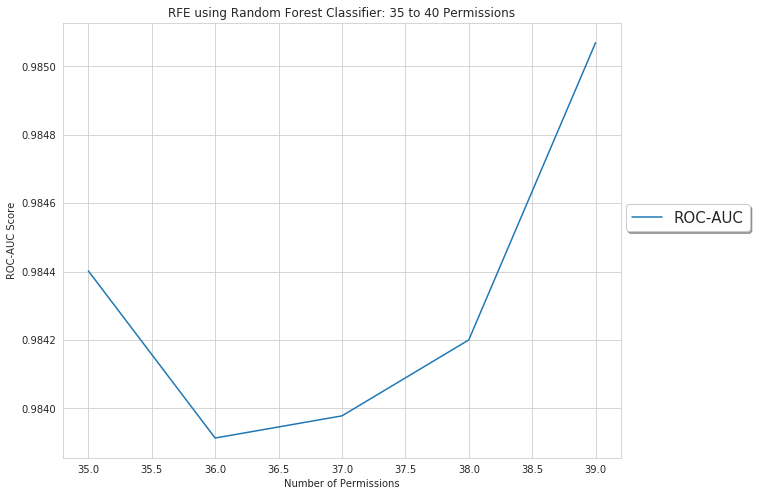

In [39]:
incremental_plot_auc(35,40,title)

In [27]:
%%time
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, 
                    n_jobs=-1), n_features_to_select=index)
    
sel.fit(X_train,y_train)
X_optimal_permission = sel.transform(X_permissions)
print(X_optimal_permission.shape)

(15036, 36)
CPU times: user 1min 9s, sys: 1.9 s, total: 1min 11s
Wall time: 43 s


In [184]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_optimal_permission,y_all, index)

Classification Report for Random Forest:    38
Accuracy: 0.9616   (+/- 0.0081)
Precision: 0.9676   (+/- 0.0081)
Recall: 0.9272   (+/- 0.0081)
F-1 Score: 0.9469   (+/- 0.0081)
ROC-AUC: 0.9886   (+/- 0.0081)
CPU times: user 61.8 ms, sys: 93.2 ms, total: 155 ms
Wall time: 6.49 s


### Significant Permissions Identification

In [19]:
import time

clear_metrics()
#X_top_feat_imps
for index in range(34,39,1):
    sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select=index)
    sel.fit(X_train, y_train)
    X_transform = sel.transform(X_validate)
#     print(X_transform.shape)
    X_corr_optimal = grouped_correlated(to_dataframe(X_transform))
#     print(X_corr_optimal.shape)
    print('Selected Feature: ', index)
    start = time.time()
    run_randomForest(X_corr_optimal, y_validate, index, with_corr=X_corr_optimal.shape[1])
    end = time.time()
    print(end - start)

(7518, 34)
(7518, 33)
Selected Feature:  34
Classification Report for Random Forest:    34
Accuracy: 0.9546   (+/- 0.0157)
Precision: 0.9620   (+/- 0.0157)
Recall: 0.9107   (+/- 0.0157)
F-1 Score: 0.9355   (+/- 0.0157)
ROC-AUC: 0.9838   (+/- 0.0157)
3.3721470832824707
(7518, 35)
(7518, 34)
Selected Feature:  35
Classification Report for Random Forest:    35
Accuracy: 0.9538   (+/- 0.0156)
Precision: 0.9587   (+/- 0.0156)
Recall: 0.9118   (+/- 0.0156)
F-1 Score: 0.9345   (+/- 0.0156)
ROC-AUC: 0.9843   (+/- 0.0156)
1.2712020874023438
(7518, 36)
(7518, 35)
Selected Feature:  36
Classification Report for Random Forest:    36
Accuracy: 0.9566   (+/- 0.0168)
Precision: 0.9615   (+/- 0.0168)
Recall: 0.9169   (+/- 0.0168)
F-1 Score: 0.9386   (+/- 0.0168)
ROC-AUC: 0.9840   (+/- 0.0168)
1.2661850452423096
(7518, 37)
(7518, 36)
Selected Feature:  37
Classification Report for Random Forest:    37
Accuracy: 0.9570   (+/- 0.0148)
Precision: 0.9619   (+/- 0.0148)
Recall: 0.9176   (+/- 0.0148)
F-1 Sco

In [20]:
title = "RFE using Random Forest Classifier with Correlation-Based Elimination"
results_to_csv(title,corr=1)

D:\Galib\MS_Thesis_Desktop\MS_Thesis\Android Malware Analysis\Drebin
1
[34, 35, 36, 37, 38] [33, 34, 35, 36, 37] [0.9546443394622773, 0.9538459359152338, 0.9566397285888317, 0.9570386647590446, 0.9582361815451736] [0.9619664155106289, 0.9586612200507787, 0.9614740742622352, 0.9618775405160285, 0.963093100553461] [0.9106617647058822, 0.9117647058823529, 0.9169117647058824, 0.9176470588235294, 0.9198529411764707] [0.9355127680921191, 0.9345404517482949, 0.9385653399578489, 0.9391530729823877, 0.9408840149727574] [0.9837575617734047, 0.9843070935478837, 0.9839963021025216, 0.9843112709919563, 0.9840039150446189]


### Combining Significant Permissions and APIs 

In [159]:
X_optimal_permissions_apis = pd.concat([to_dataframe(X_optimal_permission),to_dataframe(X_optimal_apis)], axis = 1) #concatenate column
X_optimal_permissions_apis.shape

(15036, 38)
(15036, 32)


(15036, 70)

In [160]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_optimal_permissions_apis,y_apis, index)

Classification Report for Random Forest:    32
Accuracy: 0.9860   (+/- 0.0077)
Precision: 0.9885   (+/- 0.0077)
Recall: 0.9734   (+/- 0.0077)
F-1 Score: 0.9809   (+/- 0.0077)
ROC-AUC: 0.9982   (+/- 0.0077)
CPU times: user 73.6 ms, sys: 57 ms, total: 131 ms
Wall time: 7.11 s


### Correlation Based Elimination from Combined Significant Permissions and APIS

(15036, 64)


(15036, 64)

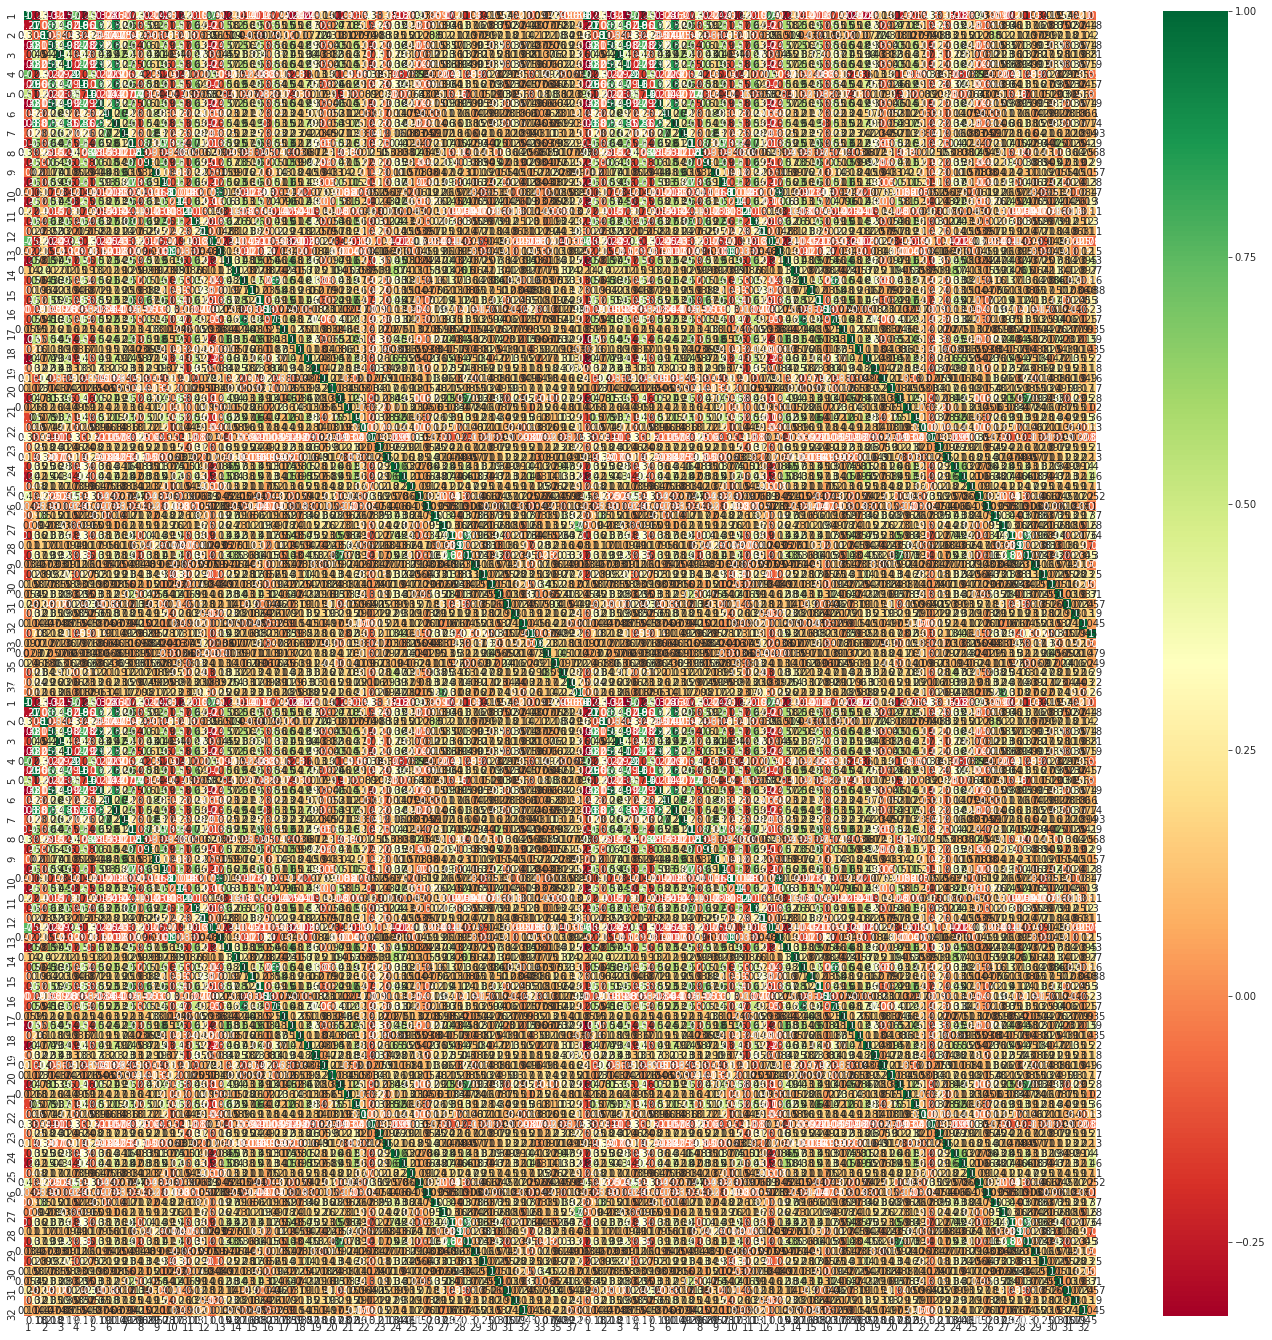

In [165]:
X_corr_optimal = grouped_correlated(X_optimal_permissions_apis)
X_corr_optimal.shape

In [168]:
%%time
#print('Selected Feature: ', index)
run_randomForest(X_corr_optimal,y_all, index)

Classification Report for Random Forest:    32
Accuracy: 0.9862   (+/- 0.0082)
Precision: 0.9889   (+/- 0.0082)
Recall: 0.9736   (+/- 0.0082)
F-1 Score: 0.9811   (+/- 0.0082)
ROC-AUC: 0.9983   (+/- 0.0082)
CPU times: user 86.4 ms, sys: 85.4 ms, total: 172 ms
Wall time: 7.06 s


### List of Significant APIs and Permissions

In [178]:
X_top_permissions = to_dataframe(X_optimal_permission)
X_top_permissions

(15036, 38)


1   2   3   4   5   6   7   8   9   10  ...  29  30  31  32  33  34  \
1       1   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
2       1   1   0   1   1   0   0   0   0   0  ...   0   0   0   0   0   0   
3       1   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
4       0   1   0   0   1   0   0   1   0   0  ...   0   0   0   0   0   1   
5       0   1   0   0   0   0   0   0   0   1  ...   0   0   0   0   0   0   
...    ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..   
15032   0   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
15033   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
15034   0   1   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   
15035   0   0   1   0   0   1   0   0   1   0  ...   0   0   0   0   0   0   
15036   0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   

       35  36  37  38  
1       0   0   1   0  
2       0   0   1   0  
3       0   0   0   0  
4       0   1   1   1  
5       0   1   0   1  
...    ..  ..  ..  ..  
15032   0   1   1   0  
15033   0   1   1   0  
15034   0   1   1   0  
15035   1   1   1   1  
15036   0   0   1   1  

[15036 rows x 38 columns]

In [180]:
selected_rfe_features = pd.DataFrame({'Feature':list(X_train.columns),
                                      'Ranking':sel.ranking_})
selected_rfe_features.sort_values(by='Ranking')

Feature  Ranking
0                 SEND_SMS        1
24        BROADCAST_STICKY        1
25               WAKE_LOCK        1
26  RECEIVE_BOOT_COMPLETED        1
61          WRITE_SETTINGS        1
..                     ...      ...
82       BIND_TEXT_SERVICE       72
96        BIND_VPN_SERVICE       73
94    SET_ACTIVITY_WATCHER       74
60     WRITE_SOCIAL_STREAM       75
50      READ_SOCIAL_STREAM       76

[113 rows x 2 columns]

In [181]:
with open('top_drebin_permissions.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Feature','Ranking'])
        writer.writerows(zip(selected_rfe_features.Feature, selected_rfe_features.Ranking))